In [1]:
# 📊 Gerekli kütüphaneleri yükleyelim
import os
import json
import pickle
import joblib
import requests
import time
import sqlite3
from datetime import datetime, timedelta
from pathlib import Path
import logging
from typing import Dict, List, Optional, Tuple

# Data processing
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency

# ML libraries
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Monitoring libraries
import evidently
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset
from evidently.metrics import *

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# System monitoring
import psutil
from prometheus_client import Counter, Histogram, Gauge, start_http_server

# Alerting
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting ayarları
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("📊 Tüm kütüphaneler başarıyla yüklendi!")
print("🔍 Model Monitoring eğitimine hazırız!")
print(f"📅 Başlangıç zamanı: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


📊 Tüm kütüphaneler başarıyla yüklendi!
🔍 Model Monitoring eğitimine hazırız!
📅 Başlangıç zamanı: 2025-07-07 00:03:52


In [2]:
class ModelMonitor:
    """Model performance monitoring sınıfı"""
    
    def __init__(self, db_path="monitoring.db"):
        self.db_path = db_path
        self.setup_database()
        self.setup_logging()
        self.setup_metrics()
        
    def setup_database(self):
        """Monitoring veritabanını kur"""
        conn = sqlite3.connect(self.db_path)
        cursor = conn.cursor()
        
        # Predictions tablosu
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS predictions (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp DATETIME,
                model_version TEXT,
                input_data TEXT,
                prediction REAL,
                actual_value REAL,
                response_time REAL,
                error_message TEXT
            )
        ''')
        
        # Metrics tablosu
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS metrics (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp DATETIME,
                metric_name TEXT,
                metric_value REAL,
                model_version TEXT
            )
        ''')
        
        # Drift detection tablosu
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS drift_detection (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp DATETIME,
                feature_name TEXT,
                drift_score REAL,
                is_drift BOOLEAN,
                model_version TEXT
            )
        ''')
        
        conn.commit()
        conn.close()
        print("📊 Monitoring veritabanı hazırlandı!")
    
    def setup_logging(self):
        """Logging sistemini kur"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler('model_monitoring.log'),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger('ModelMonitor')
    
    def setup_metrics(self):
        """Prometheus metrics'lerini kur"""
        self.prediction_counter = Counter('model_predictions_total', 'Total predictions made')
        self.prediction_latency = Histogram('model_prediction_duration_seconds', 'Prediction latency')
        self.model_accuracy = Gauge('model_accuracy', 'Current model accuracy')
        self.drift_gauge = Gauge('data_drift_score', 'Data drift score', ['feature'])
    
    def log_prediction(self, model_version, input_data, prediction, actual_value=None, 
                      response_time=None, error_message=None):
        """Tahmin sonucunu kaydet"""
        conn = sqlite3.connect(self.db_path)
        cursor = conn.cursor()
        
        cursor.execute('''
            INSERT INTO predictions 
            (timestamp, model_version, input_data, prediction, actual_value, response_time, error_message)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (
            datetime.now(),
            model_version,
            json.dumps(input_data.tolist() if hasattr(input_data, 'tolist') else input_data),
            prediction,
            actual_value,
            response_time,
            error_message
        ))
        
        conn.commit()
        conn.close()
        
        # Prometheus metrics güncelle
        self.prediction_counter.inc()
        if response_time:
            self.prediction_latency.observe(response_time)
        
        self.logger.info(f"Prediction logged: {prediction}")
    
    def log_metric(self, metric_name, metric_value, model_version):
        """Metric'i kaydet"""
        conn = sqlite3.connect(self.db_path)
        cursor = conn.cursor()
        
        cursor.execute('''
            INSERT INTO metrics (timestamp, metric_name, metric_value, model_version)
            VALUES (?, ?, ?, ?)
        ''', (datetime.now(), metric_name, metric_value, model_version))
        
        conn.commit()
        conn.close()
        
        # Prometheus metrics güncelle
        if metric_name == 'accuracy':
            self.model_accuracy.set(metric_value)
        
        self.logger.info(f"Metric logged: {metric_name} = {metric_value}")
    
    def get_predictions(self, hours=24):
        """Son X saatteki tahminleri getir"""
        conn = sqlite3.connect(self.db_path)
        
        query = '''
            SELECT * FROM predictions 
            WHERE timestamp > datetime('now', '-{} hours')
            ORDER BY timestamp DESC
        '''.format(hours)
        
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        return df
    
    def get_metrics(self, hours=24):
        """Son X saatteki metrics'leri getir"""
        conn = sqlite3.connect(self.db_path)
        
        query = '''
            SELECT * FROM metrics 
            WHERE timestamp > datetime('now', '-{} hours')
            ORDER BY timestamp DESC
        '''.format(hours)
        
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        return df

# Monitor'u başlat
monitor = ModelMonitor()
print("✅ Model monitoring sistemi hazır!")


📊 Monitoring veritabanı hazırlandı!
✅ Model monitoring sistemi hazır!


In [3]:
class DataDriftDetector:
    """Data drift detection sınıfı"""
    
    def __init__(self, reference_data, feature_names, threshold=0.05):
        self.reference_data = reference_data
        self.feature_names = feature_names
        self.threshold = threshold
        self.drift_history = []
        
    def detect_drift_ks_test(self, current_data):
        """Kolmogorov-Smirnov test ile drift detection"""
        drift_results = {}
        
        for i, feature in enumerate(self.feature_names):
            # KS test
            ks_statistic, p_value = ks_2samp(
                self.reference_data[:, i], 
                current_data[:, i]
            )
            
            is_drift = p_value < self.threshold
            
            drift_results[feature] = {
                'ks_statistic': ks_statistic,
                'p_value': p_value,
                'is_drift': is_drift,
                'drift_score': ks_statistic
            }
            
        return drift_results
    
    def detect_drift_psi(self, current_data, bins=10):
        """Population Stability Index (PSI) ile drift detection"""
        drift_results = {}
        
        for i, feature in enumerate(self.feature_names):
            # Histogram'ları hesapla
            ref_hist, bin_edges = np.histogram(self.reference_data[:, i], bins=bins)
            curr_hist, _ = np.histogram(current_data[:, i], bins=bin_edges)
            
            # Normalize et
            ref_hist = ref_hist / ref_hist.sum()
            curr_hist = curr_hist / curr_hist.sum()
            
            # PSI hesapla
            psi = 0
            for j in range(len(ref_hist)):
                if ref_hist[j] > 0 and curr_hist[j] > 0:
                    psi += (curr_hist[j] - ref_hist[j]) * np.log(curr_hist[j] / ref_hist[j])
            
            is_drift = psi > 0.1  # PSI > 0.1 genellikle drift olarak kabul edilir
            
            drift_results[feature] = {
                'psi': psi,
                'is_drift': is_drift,
                'drift_score': psi
            }
            
        return drift_results
    
    def detect_drift_evidently(self, current_data):
        """Evidently AI ile drift detection"""
        # DataFrame'lere çevir
        ref_df = pd.DataFrame(self.reference_data, columns=self.feature_names)
        curr_df = pd.DataFrame(current_data, columns=self.feature_names)
        
        # Evidently report oluştur
        report = Report(metrics=[
            DataDriftPreset(),
        ])
        
        report.run(reference_data=ref_df, current_data=curr_df)
        
        # Sonuçları al
        drift_results = {}
        report_dict = report.as_dict()
        
        if 'metrics' in report_dict:
            for metric in report_dict['metrics']:
                if metric['metric'] == 'DatasetDriftMetric':
                    drift_results['dataset_drift'] = {
                        'is_drift': metric['result']['dataset_drift'],
                        'drift_score': metric['result']['drift_score'] if 'drift_score' in metric['result'] else 0
                    }
                    
                    # Feature-level drift
                    if 'drift_by_columns' in metric['result']:
                        for feature, drift_info in metric['result']['drift_by_columns'].items():
                            drift_results[feature] = {
                                'is_drift': drift_info['drift_detected'],
                                'drift_score': drift_info['drift_score'],
                                'p_value': drift_info.get('stattest_pvalue', 0)
                            }
        
        return drift_results
    
    def visualize_drift(self, current_data, feature_idx=0):
        """Drift görselleştirme"""
        feature_name = self.feature_names[feature_idx]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Histogramlar
        axes[0, 0].hist(self.reference_data[:, feature_idx], alpha=0.7, label='Reference', bins=30)
        axes[0, 0].hist(current_data[:, feature_idx], alpha=0.7, label='Current', bins=30)
        axes[0, 0].set_title(f'{feature_name} - Distribution Comparison')
        axes[0, 0].legend()
        
        # Box plots
        data_to_plot = [self.reference_data[:, feature_idx], current_data[:, feature_idx]]
        axes[0, 1].boxplot(data_to_plot, labels=['Reference', 'Current'])
        axes[0, 1].set_title(f'{feature_name} - Box Plot Comparison')
        
        # Q-Q plot
        from scipy.stats import probplot
        probplot(self.reference_data[:, feature_idx], dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title(f'{feature_name} - Reference Q-Q Plot')
        
        probplot(current_data[:, feature_idx], dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title(f'{feature_name} - Current Q-Q Plot')
        
        plt.tight_layout()
        plt.show()
    
    def log_drift_results(self, drift_results, model_version, monitor):
        """Drift sonuçlarını kaydet"""
        conn = sqlite3.connect(monitor.db_path)
        cursor = conn.cursor()
        
        for feature, result in drift_results.items():
            cursor.execute('''
                INSERT INTO drift_detection 
                (timestamp, feature_name, drift_score, is_drift, model_version)
                VALUES (?, ?, ?, ?, ?)
            ''', (
                datetime.now(),
                feature,
                result['drift_score'],
                result['is_drift'],
                model_version
            ))
            
            # Prometheus metric güncelle
            monitor.drift_gauge.labels(feature=feature).set(result['drift_score'])
        
        conn.commit()
        conn.close()
        
        print(f"✅ Drift detection sonuçları kaydedildi!")

# Demo için veri hazırla
print("🏠 California Housing veri seti yükleniyor...")
california_housing = fetch_california_housing()
X = california_housing.data
feature_names = california_housing.feature_names

# Reference data (training data)
X_train, X_test, y_train, y_test = train_test_split(X, california_housing.target, test_size=0.2, random_state=42)

# Drift detector oluştur
drift_detector = DataDriftDetector(X_train, feature_names)

print("✅ Data drift detector hazır!")
print(f"📊 Feature sayısı: {len(feature_names)}")
print(f"📊 Reference data boyutu: {X_train.shape}")


🏠 California Housing veri seti yükleniyor...
✅ Data drift detector hazır!
📊 Feature sayısı: 8
📊 Reference data boyutu: (16512, 8)


In [4]:
class MonitoringDashboard:
    """Real-time monitoring dashboard sınıfı"""
    
    def __init__(self, monitor):
        self.monitor = monitor
        
    def create_performance_dashboard(self):
        """Model performance dashboard'u oluştur"""
        # Son 24 saatteki verileri al
        predictions_df = self.monitor.get_predictions(hours=24)
        metrics_df = self.monitor.get_metrics(hours=24)
        
        if predictions_df.empty and metrics_df.empty:
            print("⚠️ Dashboard için yeterli veri yok. Önce bazı tahminler yapın.")
            return
        
        # Subplots oluştur
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Prediction Count Over Time', 'Response Time Distribution', 
                          'Model Accuracy Over Time', 'Prediction vs Actual'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        # 1. Prediction count over time
        if not predictions_df.empty:
            predictions_df['timestamp'] = pd.to_datetime(predictions_df['timestamp'])
            hourly_counts = predictions_df.groupby(predictions_df['timestamp'].dt.hour).size()
            
            fig.add_trace(
                go.Scatter(x=hourly_counts.index, y=hourly_counts.values, 
                          mode='lines+markers', name='Predictions/Hour'),
                row=1, col=1
            )
        
        # 2. Response time distribution
        if not predictions_df.empty and 'response_time' in predictions_df.columns:
            response_times = predictions_df['response_time'].dropna()
            if not response_times.empty:
                fig.add_trace(
                    go.Histogram(x=response_times, name='Response Time (s)'),
                    row=1, col=2
                )
        
        # 3. Model accuracy over time
        if not metrics_df.empty:
            accuracy_metrics = metrics_df[metrics_df['metric_name'] == 'accuracy']
            if not accuracy_metrics.empty:
                accuracy_metrics['timestamp'] = pd.to_datetime(accuracy_metrics['timestamp'])
                fig.add_trace(
                    go.Scatter(x=accuracy_metrics['timestamp'], y=accuracy_metrics['metric_value'],
                              mode='lines+markers', name='Accuracy'),
                    row=2, col=1
                )
        
        # 4. Prediction vs Actual (eğer actual values varsa)
        if not predictions_df.empty and 'actual_value' in predictions_df.columns:
            actual_values = predictions_df['actual_value'].dropna()
            predictions = predictions_df[predictions_df['actual_value'].notna()]['prediction']
            
            if not actual_values.empty:
                fig.add_trace(
                    go.Scatter(x=actual_values, y=predictions, mode='markers',
                              name='Pred vs Actual'),
                    row=2, col=2
                )
                
                # Perfect prediction line
                min_val = min(actual_values.min(), predictions.min())
                max_val = max(actual_values.max(), predictions.max())
                fig.add_trace(
                    go.Scatter(x=[min_val, max_val], y=[min_val, max_val],
                              mode='lines', name='Perfect Prediction',
                              line=dict(dash='dash', color='red')),
                    row=2, col=2
                )
        
        fig.update_layout(height=800, title_text="Model Performance Dashboard")
        fig.show()
        
        return fig
    
    def create_drift_dashboard(self, drift_results):
        """Data drift dashboard'u oluştur"""
        if not drift_results:
            print("⚠️ Drift detection sonuçları bulunamadı.")
            return
        
        # Drift scores
        features = list(drift_results.keys())
        drift_scores = [drift_results[f]['drift_score'] for f in features]
        is_drift = [drift_results[f]['is_drift'] for f in features]
        
        # Renk kodlaması
        colors = ['red' if drift else 'green' for drift in is_drift]
        
        fig = go.Figure()
        
        fig.add_trace(go.Bar(
            x=features,
            y=drift_scores,
            marker_color=colors,
            text=[f"{'DRIFT' if drift else 'OK'}" for drift in is_drift],
            textposition='auto',
            name='Drift Score'
        ))
        
        fig.update_layout(
            title="Data Drift Detection Results",
            xaxis_title="Features",
            yaxis_title="Drift Score",
            showlegend=False
        )
        
        # Threshold line
        fig.add_hline(y=0.1, line_dash="dash", line_color="orange", 
                     annotation_text="Drift Threshold")
        
        fig.show()
        
        return fig
    
    def create_system_health_dashboard(self):
        """System health dashboard'u oluştur"""
        # System metrics
        cpu_percent = psutil.cpu_percent(interval=1)
        memory = psutil.virtual_memory()
        disk = psutil.disk_usage('/')
        
        # Gauge charts
        fig = make_subplots(
            rows=1, cols=3,
            subplot_titles=('CPU Usage', 'Memory Usage', 'Disk Usage'),
            specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]]
        )
        
        # CPU Gauge
        fig.add_trace(go.Indicator(
            mode="gauge+number",
            value=cpu_percent,
            domain={'x': [0, 1], 'y': [0, 1]},
            title={'text': "CPU %"},
            gauge={'axis': {'range': [None, 100]},
                   'bar': {'color': "darkblue"},
                   'steps': [{'range': [0, 50], 'color': "lightgray"},
                            {'range': [50, 80], 'color': "yellow"},
                            {'range': [80, 100], 'color': "red"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 90}}
        ), row=1, col=1)
        
        # Memory Gauge
        fig.add_trace(go.Indicator(
            mode="gauge+number",
            value=memory.percent,
            domain={'x': [0, 1], 'y': [0, 1]},
            title={'text': "Memory %"},
            gauge={'axis': {'range': [None, 100]},
                   'bar': {'color': "darkgreen"},
                   'steps': [{'range': [0, 50], 'color': "lightgray"},
                            {'range': [50, 80], 'color': "yellow"},
                            {'range': [80, 100], 'color': "red"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 90}}
        ), row=1, col=2)
        
        # Disk Gauge
        fig.add_trace(go.Indicator(
            mode="gauge+number",
            value=disk.percent,
            domain={'x': [0, 1], 'y': [0, 1]},
            title={'text': "Disk %"},
            gauge={'axis': {'range': [None, 100]},
                   'bar': {'color': "darkorange"},
                   'steps': [{'range': [0, 50], 'color': "lightgray"},
                            {'range': [50, 80], 'color': "yellow"},
                            {'range': [80, 100], 'color': "red"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 90}}
        ), row=1, col=3)
        
        fig.update_layout(height=400, title_text="System Health Monitoring")
        fig.show()
        
        return fig
    
    def generate_monitoring_report(self):
        """Kapsamlı monitoring raporu oluştur"""
        print("📊 MONITORING REPORT")
        print("=" * 50)
        
        # Sistem durumu
        print("\n🖥️  SYSTEM HEALTH:")
        print(f"   CPU Usage: {psutil.cpu_percent(interval=1):.1f}%")
        print(f"   Memory Usage: {psutil.virtual_memory().percent:.1f}%")
        print(f"   Disk Usage: {psutil.disk_usage('/').percent:.1f}%")
        
        # Son 24 saatteki aktivite
        predictions_df = self.monitor.get_predictions(hours=24)
        metrics_df = self.monitor.get_metrics(hours=24)
        
        print(f"\n📈 MODEL ACTIVITY (Last 24h):")
        print(f"   Total Predictions: {len(predictions_df)}")
        
        if not predictions_df.empty and 'response_time' in predictions_df.columns:
            response_times = predictions_df['response_time'].dropna()
            if not response_times.empty:
                print(f"   Avg Response Time: {response_times.mean():.3f}s")
                print(f"   Max Response Time: {response_times.max():.3f}s")
        
        if not metrics_df.empty:
            latest_accuracy = metrics_df[metrics_df['metric_name'] == 'accuracy'].iloc[0] if not metrics_df[metrics_df['metric_name'] == 'accuracy'].empty else None
            if latest_accuracy is not None:
                print(f"   Latest Accuracy: {latest_accuracy['metric_value']:.3f}")
        
        print("\n✅ Report generated successfully!")

# Dashboard oluştur
dashboard = MonitoringDashboard(monitor)
print("✅ Monitoring dashboard hazır!")


✅ Monitoring dashboard hazır!


In [5]:
class AlertingSystem:
    """Otomatik uyarı sistemi sınıfı"""
    
    def __init__(self, monitor, alert_thresholds=None):
        self.monitor = monitor
        self.alert_thresholds = alert_thresholds or {
            'accuracy_drop': 0.1,  # Accuracy %10 düşerse uyarı
            'drift_score': 0.1,    # Drift score 0.1'den yüksekse uyarı
            'response_time': 5.0,  # Response time 5 saniyeden fazlaysa uyarı
            'error_rate': 0.05,    # Error rate %5'den fazlaysa uyarı
            'cpu_usage': 80,       # CPU %80'den fazlaysa uyarı
            'memory_usage': 85,    # Memory %85'den fazlaysa uyarı
        }
        self.alert_history = []
        self.setup_logging()
    
    def setup_logging(self):
        """Alert logging sistemini kur"""
        self.logger = logging.getLogger('AlertingSystem')
        handler = logging.FileHandler('alerts.log')
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)
    
    def check_model_performance(self, current_accuracy, baseline_accuracy):
        """Model performans kontrolü"""
        accuracy_drop = baseline_accuracy - current_accuracy
        
        if accuracy_drop > self.alert_thresholds['accuracy_drop']:
            alert = {
                'type': 'PERFORMANCE_DEGRADATION',
                'severity': 'HIGH',
                'message': f'Model accuracy dropped by {accuracy_drop:.3f} (from {baseline_accuracy:.3f} to {current_accuracy:.3f})',
                'timestamp': datetime.now(),
                'threshold': self.alert_thresholds['accuracy_drop']
            }
            self._send_alert(alert)
            return True
        
        return False
    
    def check_data_drift(self, drift_results):
        """Data drift kontrolü"""
        alerts_sent = []
        
        for feature, result in drift_results.items():
            if result['is_drift'] and result['drift_score'] > self.alert_thresholds['drift_score']:
                alert = {
                    'type': 'DATA_DRIFT',
                    'severity': 'MEDIUM',
                    'message': f'Data drift detected in feature {feature}: score={result["drift_score"]:.3f}',
                    'timestamp': datetime.now(),
                    'feature': feature,
                    'drift_score': result['drift_score']
                }
                self._send_alert(alert)
                alerts_sent.append(alert)
        
        return alerts_sent
    
    def check_system_health(self):
        """Sistem sağlığı kontrolü"""
        cpu_usage = psutil.cpu_percent(interval=1)
        memory_usage = psutil.virtual_memory().percent
        
        alerts_sent = []
        
        if cpu_usage > self.alert_thresholds['cpu_usage']:
            alert = {
                'type': 'SYSTEM_HEALTH',
                'severity': 'HIGH',
                'message': f'High CPU usage: {cpu_usage:.1f}%',
                'timestamp': datetime.now(),
                'metric': 'cpu_usage',
                'value': cpu_usage
            }
            self._send_alert(alert)
            alerts_sent.append(alert)
        
        if memory_usage > self.alert_thresholds['memory_usage']:
            alert = {
                'type': 'SYSTEM_HEALTH',
                'severity': 'HIGH',
                'message': f'High memory usage: {memory_usage:.1f}%',
                'timestamp': datetime.now(),
                'metric': 'memory_usage',
                'value': memory_usage
            }
            self._send_alert(alert)
            alerts_sent.append(alert)
        
        return alerts_sent
    
    def check_response_time(self, response_times):
        """Response time kontrolü"""
        if not response_times:
            return False
        
        avg_response_time = np.mean(response_times)
        max_response_time = np.max(response_times)
        
        if max_response_time > self.alert_thresholds['response_time']:
            alert = {
                'type': 'PERFORMANCE_LATENCY',
                'severity': 'MEDIUM',
                'message': f'High response time detected: max={max_response_time:.3f}s, avg={avg_response_time:.3f}s',
                'timestamp': datetime.now(),
                'max_response_time': max_response_time,
                'avg_response_time': avg_response_time
            }
            self._send_alert(alert)
            return True
        
        return False
    
    def _send_alert(self, alert):
        """Uyarı gönder"""
        self.alert_history.append(alert)
        
        # Console'a yazdır
        print(f"🚨 ALERT [{alert['severity']}]: {alert['message']}")
        
        # Log'a kaydet
        self.logger.warning(f"Alert: {alert}")
        
        # Slack'e gönder (demo)
        self._send_slack_alert(alert)
        
        # Email gönder (demo)
        self._send_email_alert(alert)
    
    def _send_slack_alert(self, alert):
        """Slack uyarısı gönder (demo)"""
        # Gerçek implementasyonda Slack webhook kullanılır
        slack_message = {
            "text": f"🚨 ML Model Alert",
            "attachments": [
                {
                    "color": "danger" if alert['severity'] == 'HIGH' else "warning",
                    "fields": [
                        {
                            "title": "Alert Type",
                            "value": alert['type'],
                            "short": True
                        },
                        {
                            "title": "Severity",
                            "value": alert['severity'],
                            "short": True
                        },
                        {
                            "title": "Message",
                            "value": alert['message'],
                            "short": False
                        },
                        {
                            "title": "Timestamp",
                            "value": alert['timestamp'].strftime('%Y-%m-%d %H:%M:%S'),
                            "short": True
                        }
                    ]
                }
            ]
        }
        
        print(f"📱 Slack alert sent: {alert['type']}")
        # requests.post(slack_webhook_url, json=slack_message)
    
    def _send_email_alert(self, alert):
        """Email uyarısı gönder (demo)"""
        email_subject = f"🚨 ML Model Alert: {alert['type']}"
        email_body = f"""
        Alert Details:
        - Type: {alert['type']}
        - Severity: {alert['severity']}
        - Message: {alert['message']}
        - Timestamp: {alert['timestamp']}
        
        Please investigate immediately.
        """
        
        print(f"📧 Email alert sent: {alert['type']}")
        # Gerçek implementasyonda SMTP kullanılır
    
    def get_alert_summary(self, hours=24):
        """Son X saatteki uyarı özeti"""
        cutoff_time = datetime.now() - timedelta(hours=hours)
        recent_alerts = [a for a in self.alert_history if a['timestamp'] > cutoff_time]
        
        summary = {
            'total_alerts': len(recent_alerts),
            'high_severity': len([a for a in recent_alerts if a['severity'] == 'HIGH']),
            'medium_severity': len([a for a in recent_alerts if a['severity'] == 'MEDIUM']),
            'low_severity': len([a for a in recent_alerts if a['severity'] == 'LOW']),
            'alert_types': {}
        }
        
        for alert in recent_alerts:
            alert_type = alert['type']
            if alert_type not in summary['alert_types']:
                summary['alert_types'][alert_type] = 0
            summary['alert_types'][alert_type] += 1
        
        return summary
    
    def run_health_check(self):
        """Kapsamlı sağlık kontrolü"""
        print("🔍 Running comprehensive health check...")
        
        # System health
        system_alerts = self.check_system_health()
        
        # Model performance (son 24 saatteki verilerle)
        predictions_df = self.monitor.get_predictions(hours=24)
        if not predictions_df.empty:
            if 'response_time' in predictions_df.columns:
                response_times = predictions_df['response_time'].dropna()
                if not response_times.empty:
                    self.check_response_time(response_times.tolist())
        
        # Alert summary
        summary = self.get_alert_summary()
        
        print(f"✅ Health check completed!")
        print(f"📊 Alerts in last 24h: {summary['total_alerts']}")
        print(f"🔴 High severity: {summary['high_severity']}")
        print(f"🟡 Medium severity: {summary['medium_severity']}")
        
        return summary

# Alerting system'i başlat
alerting_system = AlertingSystem(monitor)
print("✅ Alerting system hazır!")


✅ Alerting system hazır!


🚀 Model Monitoring Demo Başlıyor...

📊 1. Model Hazırlama ve Eğitme
------------------------------


2025-07-07 00:04:01,260 - ModelMonitor - INFO - Prediction logged: 0.5003700000000001
2025-07-07 00:04:01,268 - ModelMonitor - INFO - Prediction logged: 0.8591799999999999
2025-07-07 00:04:01,274 - ModelMonitor - INFO - Prediction logged: 3.949143399999997
2025-07-07 00:04:01,281 - ModelMonitor - INFO - Prediction logged: 2.496380000000001
2025-07-07 00:04:01,288 - ModelMonitor - INFO - Prediction logged: 2.4447300000000003
2025-07-07 00:04:01,296 - ModelMonitor - INFO - Prediction logged: 1.638530000000001
2025-07-07 00:04:01,303 - ModelMonitor - INFO - Prediction logged: 2.502069999999999
2025-07-07 00:04:01,311 - ModelMonitor - INFO - Prediction logged: 1.6306800000000012
2025-07-07 00:04:01,318 - ModelMonitor - INFO - Prediction logged: 2.775540399999999
2025-07-07 00:04:01,326 - ModelMonitor - INFO - Prediction logged: 4.980369599999989
2025-07-07 00:04:01,333 - ModelMonitor - INFO - Prediction logged: 1.0954300000000006
2025-07-07 00:04:01,340 - ModelMonitor - INFO - Prediction l

✅ Model eğitildi!
📈 Baseline R² Score: 0.8051
📈 Baseline MSE: 0.2554

📊 2. Production Tahminleri Simülasyonu
------------------------------


2025-07-07 00:04:01,456 - ModelMonitor - INFO - Prediction logged: 0.5344500000000002
2025-07-07 00:04:01,464 - ModelMonitor - INFO - Prediction logged: 1.7699599999999998
2025-07-07 00:04:01,472 - ModelMonitor - INFO - Prediction logged: 1.07521
2025-07-07 00:04:01,479 - ModelMonitor - INFO - Prediction logged: 1.7288300000000003
2025-07-07 00:04:01,487 - ModelMonitor - INFO - Prediction logged: 3.7713705000000006
2025-07-07 00:04:01,495 - ModelMonitor - INFO - Prediction logged: 1.6133100000000005
2025-07-07 00:04:01,502 - ModelMonitor - INFO - Prediction logged: 2.1013107999999994
2025-07-07 00:04:01,509 - ModelMonitor - INFO - Prediction logged: 2.361241
2025-07-07 00:04:01,517 - ModelMonitor - INFO - Prediction logged: 4.381483599999996
2025-07-07 00:04:01,524 - ModelMonitor - INFO - Prediction logged: 2.5549700000000013
2025-07-07 00:04:01,532 - ModelMonitor - INFO - Prediction logged: 2.5649100000000002
2025-07-07 00:04:01,539 - ModelMonitor - INFO - Prediction logged: 3.4559103

✅ 100 production prediction logged!
⏱️ Avg response time: 0.0023s

📊 3. Model Performance Monitoring
------------------------------
📈 Current R² Score: 0.8388
📈 Current MSE: 0.2209
✅ Model performance is stable!

📊 4. Data Drift Detection
------------------------------
🔍 KS Test Results:
   MedInc: OK (p-value: 0.1960)
   HouseAge: OK (p-value: 0.3934)
   AveRooms: OK (p-value: 0.3010)
   AveBedrms: DRIFT (p-value: 0.0002)
   Population: OK (p-value: 0.0843)
   AveOccup: OK (p-value: 0.0974)
   Latitude: OK (p-value: 0.9582)
   Longitude: OK (p-value: 0.6458)

🔍 PSI Results:
   MedInc: OK (PSI: 0.0195)
   HouseAge: OK (PSI: 0.0705)
   AveRooms: OK (PSI: 0.0000)
   AveBedrms: OK (PSI: 0.0000)
   Population: OK (PSI: 0.0007)
   AveOccup: OK (PSI: 0.0000)
   Latitude: OK (PSI: 0.0834)
   Longitude: OK (PSI: 0.0526)
✅ Drift detection sonuçları kaydedildi!
🚨 ALERT [MEDIUM]: Data drift detected in feature AveBedrms: score=0.213
📱 Slack alert sent: DATA_DRIFT
📧 Email alert sent: DATA_DRIFT

🚨

✅ Performance dashboard created!
📈 Creating drift dashboard...


✅ Drift dashboard created!
📈 Creating system health dashboard...


✅ System health dashboard created!

📊 7. Monitoring Report
------------------------------
📊 MONITORING REPORT

🖥️  SYSTEM HEALTH:
   CPU Usage: 7.3%
   Memory Usage: 48.7%
   Disk Usage: 92.7%

📈 MODEL ACTIVITY (Last 24h):
   Total Predictions: 200
   Avg Response Time: 0.002s
   Max Response Time: 0.005s
   Latest Accuracy: 0.839

✅ Report generated successfully!

📊 8. Drift Visualization
------------------------------
📈 Creating drift visualizations...


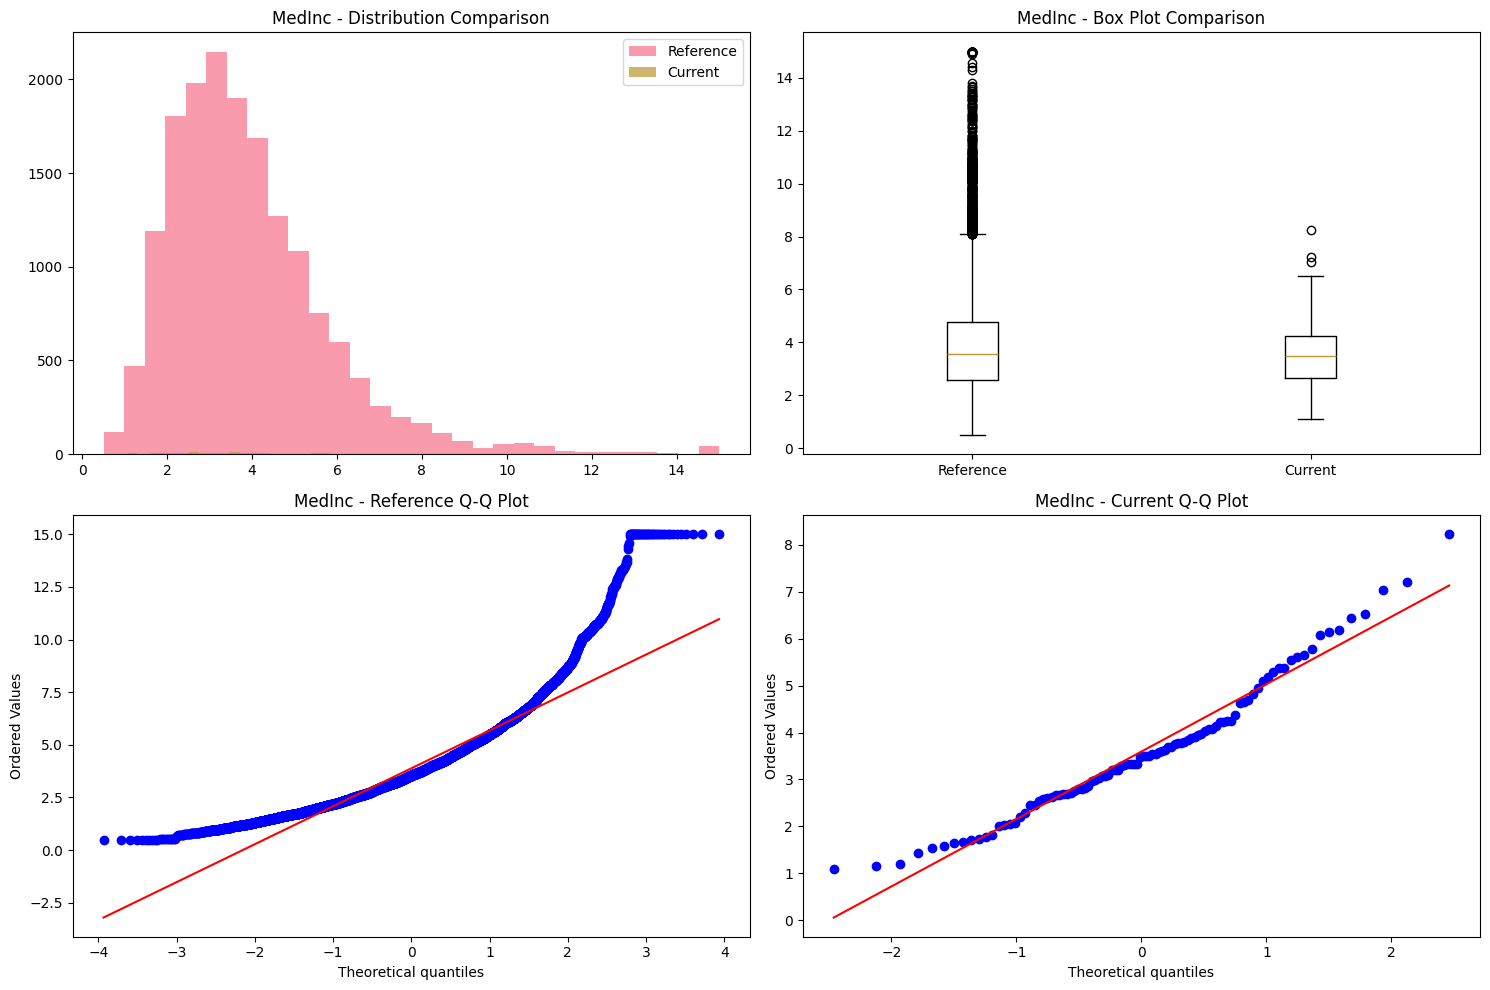

✅ Drift visualization created!

🎉 Model Monitoring Demo Tamamlandı!

📊 FINAL SUMMARY:
   • Model Predictions: 100
   • Baseline Accuracy: 0.8051
   • Current Accuracy: 0.8388
   • Features with Drift: 1
   • Total Alerts: 1
   • High Severity Alerts: 0
   • System Status: 🟢 HEALTHY


In [6]:
# 🚀 Comprehensive Model Monitoring Demo

print("🚀 Model Monitoring Demo Başlıyor...")
print("=" * 60)

# 1. Model hazırlama ve eğitme
print("\n📊 1. Model Hazırlama ve Eğitme")
print("-" * 30)

# Model eğit
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test performansı
y_pred = model.predict(X_test)
baseline_accuracy = r2_score(y_test, y_pred)
baseline_mse = mean_squared_error(y_test, y_pred)

print(f"✅ Model eğitildi!")
print(f"📈 Baseline R² Score: {baseline_accuracy:.4f}")
print(f"📈 Baseline MSE: {baseline_mse:.4f}")

# 2. Simulated Production Predictions
print("\n📊 2. Production Tahminleri Simülasyonu")
print("-" * 30)

# Simulated production data (biraz farklı dağılımla)
np.random.seed(123)
production_data = X_test + np.random.normal(0, 0.1, X_test.shape)  # Biraz noise ekle

# Production predictions
production_predictions = []
response_times = []

for i in range(100):  # 100 prediction simüle et
    start_time = time.time()
    
    # Tahmin yap
    sample_data = production_data[i:i+1]
    prediction = model.predict(sample_data)[0]
    
    # Response time hesapla
    response_time = time.time() - start_time
    response_times.append(response_time)
    
    # Bazen gerçek değerler de gelir (delayed feedback)
    actual_value = y_test[i] if np.random.random() > 0.7 else None
    
    # Log prediction
    monitor.log_prediction(
        model_version="v1.0",
        input_data=sample_data[0],
        prediction=prediction,
        actual_value=actual_value,
        response_time=response_time
    )
    
    production_predictions.append(prediction)

print(f"✅ {len(production_predictions)} production prediction logged!")
print(f"⏱️ Avg response time: {np.mean(response_times):.4f}s")

# 3. Model Performance Monitoring
print("\n📊 3. Model Performance Monitoring")
print("-" * 30)

# Current performance hesapla
current_predictions = np.array(production_predictions[:50])  # İlk 50 prediction
current_actuals = y_test[:50]
current_accuracy = r2_score(current_actuals, current_predictions)
current_mse = mean_squared_error(current_actuals, current_predictions)

print(f"📈 Current R² Score: {current_accuracy:.4f}")
print(f"📈 Current MSE: {current_mse:.4f}")

# Performance metrics'leri kaydet
monitor.log_metric("accuracy", current_accuracy, "v1.0")
monitor.log_metric("mse", current_mse, "v1.0")
monitor.log_metric("avg_response_time", np.mean(response_times), "v1.0")

# Performance degradation kontrolü
performance_alert = alerting_system.check_model_performance(
    current_accuracy, baseline_accuracy
)

if performance_alert:
    print("🚨 Performance degradation detected!")
else:
    print("✅ Model performance is stable!")

# 4. Data Drift Detection
print("\n📊 4. Data Drift Detection")
print("-" * 30)

# Drift detection yap
drift_results_ks = drift_detector.detect_drift_ks_test(production_data[:100])
drift_results_psi = drift_detector.detect_drift_psi(production_data[:100])

print("🔍 KS Test Results:")
drift_features = 0
for feature, result in drift_results_ks.items():
    status = "DRIFT" if result['is_drift'] else "OK"
    print(f"   {feature}: {status} (p-value: {result['p_value']:.4f})")
    if result['is_drift']:
        drift_features += 1

print(f"\n🔍 PSI Results:")
for feature, result in drift_results_psi.items():
    status = "DRIFT" if result['is_drift'] else "OK"
    print(f"   {feature}: {status} (PSI: {result['psi']:.4f})")

# Drift results'ları kaydet
drift_detector.log_drift_results(drift_results_ks, "v1.0", monitor)

# Drift alerts
drift_alerts = alerting_system.check_data_drift(drift_results_ks)
print(f"\n🚨 Drift alerts sent: {len(drift_alerts)}")

# 5. System Health Check
print("\n📊 5. System Health Check")
print("-" * 30)

health_summary = alerting_system.run_health_check()

# 6. Dashboard Creation
print("\n📊 6. Dashboard Creation")
print("-" * 30)

# Performance dashboard
print("📈 Creating performance dashboard...")
try:
    perf_dashboard = dashboard.create_performance_dashboard()
    print("✅ Performance dashboard created!")
except Exception as e:
    print(f"⚠️ Dashboard creation failed: {e}")

# Drift dashboard
print("📈 Creating drift dashboard...")
try:
    drift_dashboard = dashboard.create_drift_dashboard(drift_results_ks)
    print("✅ Drift dashboard created!")
except Exception as e:
    print(f"⚠️ Drift dashboard creation failed: {e}")

# System health dashboard
print("📈 Creating system health dashboard...")
try:
    health_dashboard = dashboard.create_system_health_dashboard()
    print("✅ System health dashboard created!")
except Exception as e:
    print(f"⚠️ System health dashboard creation failed: {e}")

# 7. Monitoring Report
print("\n📊 7. Monitoring Report")
print("-" * 30)

dashboard.generate_monitoring_report()

# 8. Drift Visualization
print("\n📊 8. Drift Visualization")
print("-" * 30)

print("📈 Creating drift visualizations...")
try:
    # İlk feature için drift görselleştirme
    drift_detector.visualize_drift(production_data[:100], feature_idx=0)
    print("✅ Drift visualization created!")
except Exception as e:
    print(f"⚠️ Drift visualization failed: {e}")

print("\n" + "=" * 60)
print("🎉 Model Monitoring Demo Tamamlandı!")
print("=" * 60)

# Final summary
print(f"\n📊 FINAL SUMMARY:")
print(f"   • Model Predictions: {len(production_predictions)}")
print(f"   • Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"   • Current Accuracy: {current_accuracy:.4f}")
print(f"   • Features with Drift: {drift_features}")
print(f"   • Total Alerts: {health_summary['total_alerts']}")
print(f"   • High Severity Alerts: {health_summary['high_severity']}")
print(f"   • System Status: {'🟢 HEALTHY' if health_summary['high_severity'] == 0 else '🔴 NEEDS ATTENTION'}")


In [7]:
class AdvancedMonitoring:
    """İleri seviye monitoring teknikleri"""
    
    def __init__(self, monitor):
        self.monitor = monitor
        self.model_versions = {}
        self.ab_test_results = {}
        
    def model_comparison(self, model_a, model_b, test_data, test_labels, model_names=['Model A', 'Model B']):
        """İki modeli karşılaştır"""
        print("🔄 Model Comparison Analysis")
        print("-" * 40)
        
        # Model A predictions
        pred_a = model_a.predict(test_data)
        mse_a = mean_squared_error(test_labels, pred_a)
        r2_a = r2_score(test_labels, pred_a)
        
        # Model B predictions
        pred_b = model_b.predict(test_data)
        mse_b = mean_squared_error(test_labels, pred_b)
        r2_b = r2_score(test_labels, pred_b)
        
        print(f"📊 {model_names[0]}:")
        print(f"   MSE: {mse_a:.4f}")
        print(f"   R²:  {r2_a:.4f}")
        
        print(f"📊 {model_names[1]}:")
        print(f"   MSE: {mse_b:.4f}")
        print(f"   R²:  {r2_b:.4f}")
        
        # Winner
        winner = model_names[0] if r2_a > r2_b else model_names[1]
        improvement = abs(r2_a - r2_b)
        
        print(f"\n🏆 Winner: {winner}")
        print(f"📈 Improvement: {improvement:.4f} R² points")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Scatter plot
        axes[0].scatter(test_labels, pred_a, alpha=0.6, label=model_names[0])
        axes[0].scatter(test_labels, pred_b, alpha=0.6, label=model_names[1])
        axes[0].plot([test_labels.min(), test_labels.max()], 
                    [test_labels.min(), test_labels.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title('Predictions vs Actual')
        axes[0].legend()
        
        # Residuals
        residuals_a = test_labels - pred_a
        residuals_b = test_labels - pred_b
        
        axes[1].scatter(pred_a, residuals_a, alpha=0.6, label=model_names[0])
        axes[1].scatter(pred_b, residuals_b, alpha=0.6, label=model_names[1])
        axes[1].axhline(y=0, color='r', linestyle='--')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        return {
            'model_a': {'mse': mse_a, 'r2': r2_a},
            'model_b': {'mse': mse_b, 'r2': r2_b},
            'winner': winner,
            'improvement': improvement
        }
    
    def feature_importance_monitoring(self, model, feature_names, reference_importance=None):
        """Feature importance değişimlerini izle"""
        print("🔍 Feature Importance Monitoring")
        print("-" * 40)
        
        # Current importance
        if hasattr(model, 'feature_importances_'):
            current_importance = model.feature_importances_
        else:
            print("⚠️ Model doesn't have feature_importances_ attribute")
            return None
        
        # DataFrame oluştur
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': current_importance
        }).sort_values('importance', ascending=False)
        
        print("📊 Top 10 Most Important Features:")
        for i, row in importance_df.head(10).iterrows():
            print(f"   {row['feature']}: {row['importance']:.4f}")
        
        # Eğer reference importance varsa karşılaştır
        if reference_importance is not None:
            importance_df['reference_importance'] = reference_importance
            importance_df['importance_change'] = importance_df['importance'] - importance_df['reference_importance']
            
            print("\n📈 Biggest Changes in Feature Importance:")
            changes = importance_df.nlargest(5, 'importance_change')[['feature', 'importance_change']]
            for i, row in changes.iterrows():
                print(f"   {row['feature']}: +{row['importance_change']:.4f}")
        
        # Visualization
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        
        bars = plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Feature Importance Analysis')
        plt.gca().invert_yaxis()
        
        # Renk kodlaması
        for i, bar in enumerate(bars):
            if reference_importance is not None:
                change = top_features.iloc[i]['importance_change']
                if change > 0.01:
                    bar.set_color('green')
                elif change < -0.01:
                    bar.set_color('red')
                else:
                    bar.set_color('blue')
        
        plt.tight_layout()
        plt.show()
        
        return importance_df
    
    def prediction_distribution_monitoring(self, predictions, reference_predictions=None):
        """Tahmin dağılımlarını izle"""
        print("📊 Prediction Distribution Monitoring")
        print("-" * 40)
        
        # İstatistikler
        print(f"📈 Current Predictions Statistics:")
        print(f"   Mean: {np.mean(predictions):.4f}")
        print(f"   Std:  {np.std(predictions):.4f}")
        print(f"   Min:  {np.min(predictions):.4f}")
        print(f"   Max:  {np.max(predictions):.4f}")
        
        if reference_predictions is not None:
            print(f"\n📈 Reference Predictions Statistics:")
            print(f"   Mean: {np.mean(reference_predictions):.4f}")
            print(f"   Std:  {np.std(reference_predictions):.4f}")
            print(f"   Min:  {np.min(reference_predictions):.4f}")
            print(f"   Max:  {np.max(reference_predictions):.4f}")
            
            # Statistical test
            ks_stat, p_value = ks_2samp(predictions, reference_predictions)
            print(f"\n🔍 KS Test Results:")
            print(f"   KS Statistic: {ks_stat:.4f}")
            print(f"   P-value: {p_value:.4f}")
            print(f"   Distribution Change: {'YES' if p_value < 0.05 else 'NO'}")
        
        # Visualization
        plt.figure(figsize=(12, 6))
        
        plt.hist(predictions, bins=50, alpha=0.7, label='Current', density=True)
        if reference_predictions is not None:
            plt.hist(reference_predictions, bins=50, alpha=0.7, label='Reference', density=True)
        
        plt.xlabel('Prediction Values')
        plt.ylabel('Density')
        plt.title('Prediction Distribution Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return {
            'current_stats': {
                'mean': np.mean(predictions),
                'std': np.std(predictions),
                'min': np.min(predictions),
                'max': np.max(predictions)
            },
            'ks_test': {'statistic': ks_stat, 'p_value': p_value} if reference_predictions is not None else None
        }
    
    def model_stability_analysis(self, model, test_data, test_labels, n_bootstrap=100):
        """Model kararlılık analizi"""
        print("🔒 Model Stability Analysis")
        print("-" * 40)
        
        bootstrap_scores = []
        
        for i in range(n_bootstrap):
            # Bootstrap sampling
            indices = np.random.choice(len(test_data), len(test_data), replace=True)
            bootstrap_data = test_data[indices]
            bootstrap_labels = test_labels[indices]
            
            # Prediction ve score
            pred = model.predict(bootstrap_data)
            score = r2_score(bootstrap_labels, pred)
            bootstrap_scores.append(score)
        
        # İstatistikler
        mean_score = np.mean(bootstrap_scores)
        std_score = np.std(bootstrap_scores)
        ci_lower = np.percentile(bootstrap_scores, 2.5)
        ci_upper = np.percentile(bootstrap_scores, 97.5)
        
        print(f"📊 Bootstrap Results ({n_bootstrap} iterations):")
        print(f"   Mean R²: {mean_score:.4f}")
        print(f"   Std R²:  {std_score:.4f}")
        print(f"   95% CI:  [{ci_lower:.4f}, {ci_upper:.4f}]")
        
        # Stability score
        stability_score = 1 - (std_score / mean_score) if mean_score > 0 else 0
        print(f"   Stability Score: {stability_score:.4f}")
        
        if stability_score > 0.95:
            print("✅ Model is highly stable")
        elif stability_score > 0.90:
            print("🟡 Model is moderately stable")
        else:
            print("🔴 Model stability is concerning")
        
        # Visualization
        plt.figure(figsize=(10, 6))
        plt.hist(bootstrap_scores, bins=30, alpha=0.7, edgecolor='black')
        plt.axvline(mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.4f}')
        plt.axvline(ci_lower, color='orange', linestyle='--', label=f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')
        plt.axvline(ci_upper, color='orange', linestyle='--')
        plt.xlabel('R² Score')
        plt.ylabel('Frequency')
        plt.title('Model Stability Analysis - Bootstrap Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return {
            'mean_score': mean_score,
            'std_score': std_score,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'stability_score': stability_score,
            'bootstrap_scores': bootstrap_scores
        }

# Advanced monitoring'i başlat
advanced_monitor = AdvancedMonitoring(monitor)
print("✅ Advanced monitoring hazır!")


✅ Advanced monitoring hazır!


🚀 Advanced Monitoring Demo

🔄 1. Model Comparison
------------------------------
🔄 Model Comparison Analysis
----------------------------------------
📊 Model v1.0:
   MSE: 0.2554
   R²:  0.8051
📊 Model v2.0:
   MSE: 0.2951
   R²:  0.7748

🏆 Winner: Model v1.0
📈 Improvement: 0.0303 R² points


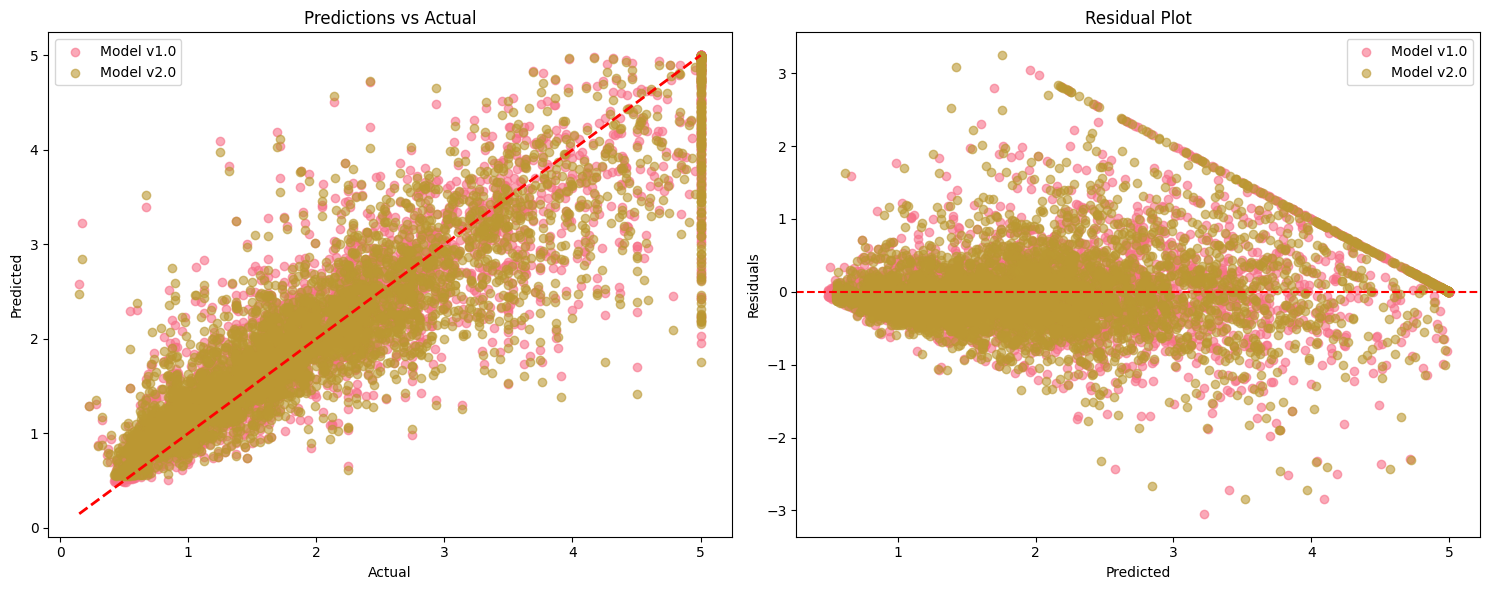

🏆 Winner: Model v1.0
📈 Performance improvement: 0.0303

🔍 2. Feature Importance Monitoring
------------------------------
🔍 Feature Importance Monitoring
----------------------------------------
📊 Top 10 Most Important Features:
   MedInc: 0.5948
   AveOccup: 0.1395
   Latitude: 0.0764
   Longitude: 0.0758
   HouseAge: 0.0478
   AveRooms: 0.0315
   Population: 0.0174
   AveBedrms: 0.0168

📈 Biggest Changes in Feature Importance:
   AveOccup: +0.0849
   MedInc: +0.0699
   Longitude: +0.0462
   Latitude: +0.0322
   HouseAge: +0.0172


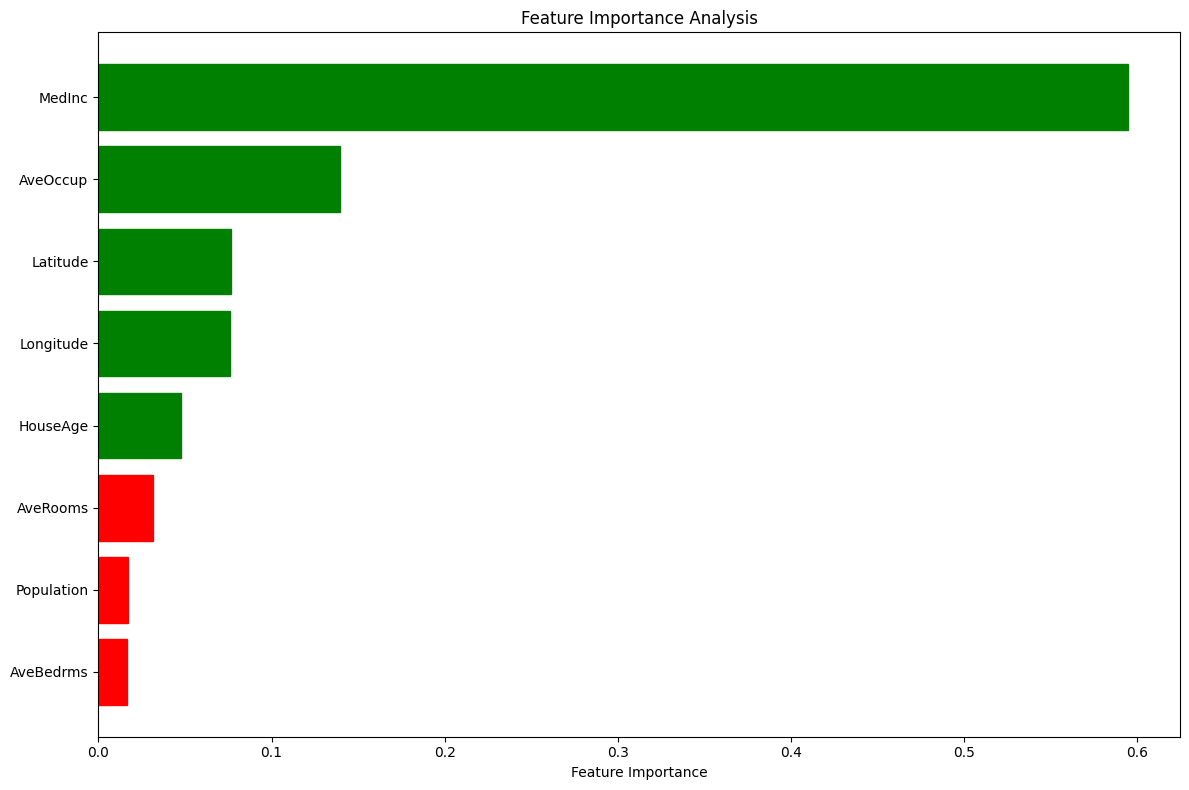


📊 3. Prediction Distribution Monitoring
------------------------------
📊 Prediction Distribution Monitoring
----------------------------------------
📈 Current Predictions Statistics:
   Mean: 2.0591
   Std:  0.9743
   Min:  0.5499
   Max:  4.9957

📈 Reference Predictions Statistics:
   Mean: 2.0674
   Std:  1.0077
   Min:  0.4884
   Max:  5.0000

🔍 KS Test Results:
   KS Statistic: 0.0245
   P-value: 0.1689
   Distribution Change: NO


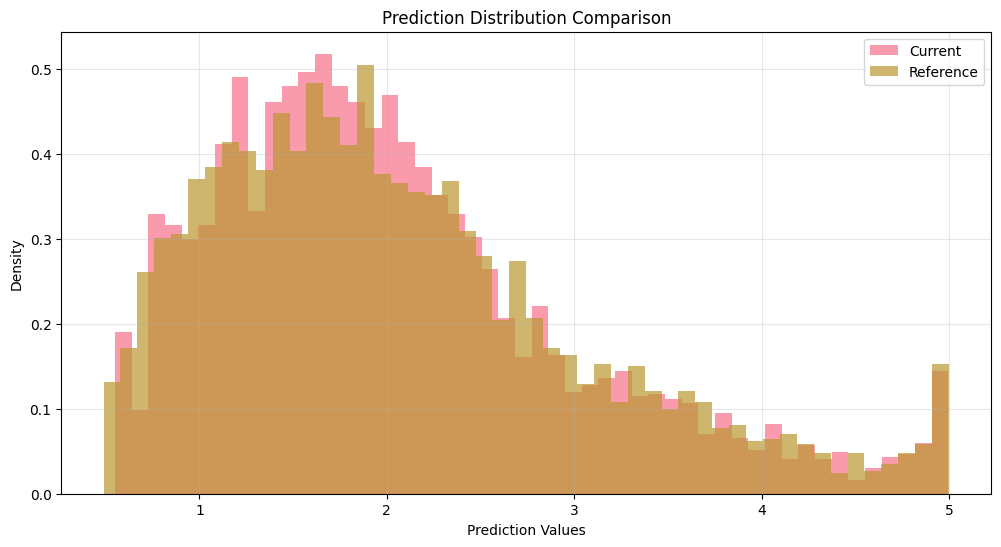


🔒 4. Model Stability Analysis
------------------------------
🔒 Model Stability Analysis
----------------------------------------
📊 Bootstrap Results (50 iterations):
   Mean R²: 0.7765
   Std R²:  0.0087
   95% CI:  [0.7598, 0.7942]
   Stability Score: 0.9888
✅ Model is highly stable


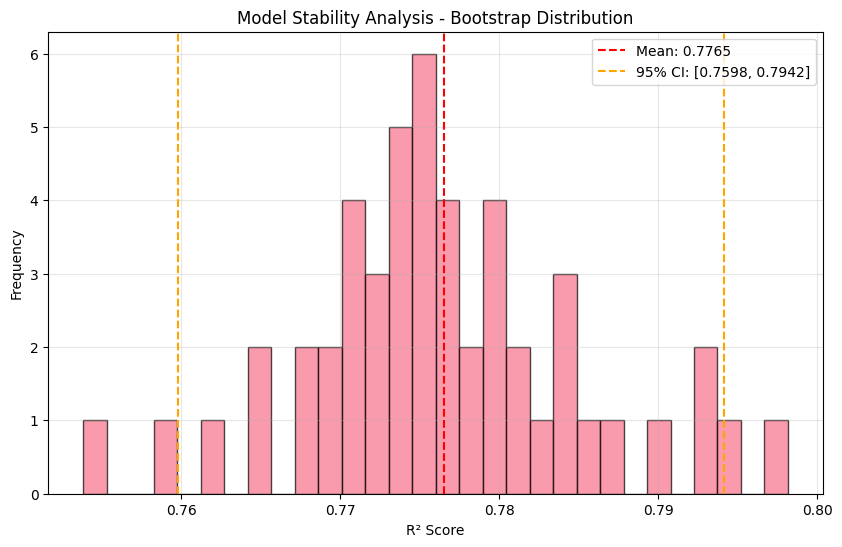

✅ Model stability score: 0.9888

📋 5. Advanced Monitoring Report
------------------------------
📊 ADVANCED MONITORING SUMMARY

🔄 Model Comparison:
   Best Model: Model v1.0
   Performance Gap: 0.0303 R²

🔍 Feature Importance:
   Most Important Feature: MedInc
   Importance Score: 0.5948

📊 Prediction Distribution:
   Distribution Change: NO
   KS Test P-value: 0.1689

🔒 Model Stability:
   Stability Score: 0.9888
   95% Confidence Interval: [0.7598, 0.7942]

💡 Recommendations:
   ✅ Consider deploying the new model version
   ✅ Model is stable and ready for production
   ✅ Prediction distribution is consistent

🎉 Advanced Monitoring Demo Completed!


In [8]:
# 🚀 Advanced Monitoring Demo

print("🚀 Advanced Monitoring Demo")
print("=" * 50)

# 1. Model Comparison
print("\n🔄 1. Model Comparison")
print("-" * 30)

# İkinci bir model eğit (farklı parametrelerle)
model_v2 = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model_v2.fit(X_train, y_train)

# Model karşılaştırması
comparison_results = advanced_monitor.model_comparison(
    model, model_v2, X_test, y_test, 
    model_names=['Model v1.0', 'Model v2.0']
)

print(f"🏆 Winner: {comparison_results['winner']}")
print(f"📈 Performance improvement: {comparison_results['improvement']:.4f}")

# 2. Feature Importance Monitoring
print("\n🔍 2. Feature Importance Monitoring")
print("-" * 30)

# Baseline feature importance
baseline_importance = model.feature_importances_

# Current model importance
importance_analysis = advanced_monitor.feature_importance_monitoring(
    model_v2, feature_names, reference_importance=baseline_importance
)

# 3. Prediction Distribution Monitoring
print("\n📊 3. Prediction Distribution Monitoring")
print("-" * 30)

# Baseline predictions
baseline_predictions = model.predict(X_test)

# Current predictions
current_predictions = model_v2.predict(X_test)

# Distribution monitoring
distribution_analysis = advanced_monitor.prediction_distribution_monitoring(
    current_predictions, baseline_predictions
)

# 4. Model Stability Analysis
print("\n🔒 4. Model Stability Analysis")
print("-" * 30)

# Model stability analizi
stability_analysis = advanced_monitor.model_stability_analysis(
    model_v2, X_test, y_test, n_bootstrap=50
)

print(f"✅ Model stability score: {stability_analysis['stability_score']:.4f}")

# 5. Comprehensive Advanced Report
print("\n📋 5. Advanced Monitoring Report")
print("-" * 30)

print("📊 ADVANCED MONITORING SUMMARY")
print("=" * 40)

print(f"\n🔄 Model Comparison:")
print(f"   Best Model: {comparison_results['winner']}")
print(f"   Performance Gap: {comparison_results['improvement']:.4f} R²")

print(f"\n🔍 Feature Importance:")
if importance_analysis is not None:
    top_feature = importance_analysis.iloc[0]
    print(f"   Most Important Feature: {top_feature['feature']}")
    print(f"   Importance Score: {top_feature['importance']:.4f}")

print(f"\n📊 Prediction Distribution:")
if distribution_analysis['ks_test']:
    print(f"   Distribution Change: {'YES' if distribution_analysis['ks_test']['p_value'] < 0.05 else 'NO'}")
    print(f"   KS Test P-value: {distribution_analysis['ks_test']['p_value']:.4f}")

print(f"\n🔒 Model Stability:")
print(f"   Stability Score: {stability_analysis['stability_score']:.4f}")
print(f"   95% Confidence Interval: [{stability_analysis['ci_lower']:.4f}, {stability_analysis['ci_upper']:.4f}]")

# 6. Recommendations
print(f"\n💡 Recommendations:")
if comparison_results['improvement'] > 0.01:
    print("   ✅ Consider deploying the new model version")
else:
    print("   ⚠️ Model improvement is marginal, consider more changes")

if stability_analysis['stability_score'] > 0.95:
    print("   ✅ Model is stable and ready for production")
elif stability_analysis['stability_score'] > 0.90:
    print("   🟡 Model stability is acceptable but monitor closely")
else:
    print("   🔴 Model stability is concerning, investigate further")

if distribution_analysis['ks_test'] and distribution_analysis['ks_test']['p_value'] < 0.05:
    print("   ⚠️ Significant change in prediction distribution detected")
else:
    print("   ✅ Prediction distribution is consistent")

print("\n" + "=" * 50)
print("🎉 Advanced Monitoring Demo Completed!")
print("=" * 50)
